In [2]:
from gensim import corpora, models, similarities, matutils, utils
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import metrics
from nltk import FreqDist
import pandas as pd
import numpy as np
import time
import nltk
import re
import os

# DO NOT RUN THIS PART

In [3]:
subd=pd.read_hdf('Sub_data.h5', 'subs')
movd=pd.read_hdf('movbaseB.h5', 'imdb_id')

In [4]:
tokenizer = RegexpTokenizer("\w+")
stop_words=set(stopwords.words('english'))

In [5]:
print('Number subs in database: {}'.format(len(subd.columns.levels[0])))
print('Here are the shitty ones:')
t0 = time.time()
for item in subd.columns.levels[0]:
    n_lines=len(subd[item][subd[item]['Line'] != ''])  #number of lines
    num_s=[item2 in ' '.join(subd[item]['Line']).strip().lower() for item2 in stop_words].count(True) #number of stop words
    if n_lines < 100 or num_s < 100:
        print('{}-{}-{} :: '.format(movd[movd.imdb_id == item]['Title'].values[0],item,num_s),end=' ')
        subd.drop(item,axis=1,level=0,inplace=True)
        subd.columns = pd.MultiIndex.from_tuples(subd.columns.to_series())
t1 = time.time()
print('Number subs after removel of shitty ones: {}'.format(len(subd.columns.levels[0])))        
print('Time elapsed cleaning: {}'.format(t1-t0))

Number subs in database: 1601
Here are the shitty ones:
Love Story-0066011-0 ::  American Graffiti-0069704-0 ::  Coal Miner's Daughter-0080549-0 ::  An Officer and a Gentleman-0084434-0 ::  Staying Alive-0086361-0 ::  The Color Purple-0088939-0 ::  The Bear-0095800-81 ::  The Living Sea-0113676-0 ::  Outbreak-0114069-60 ::  Babe: Pig in the City-0120595-0 ::  The Wedding Singer-0120888-0 ::  Fantasia 2000-0120910-0 ::  Message in a Bottle-0139462-0 ::  Runaway Bride-0163187-0 ::  Drumline-0303933-0 ::  The Exorcism of Emily Rose-0404032-19 ::  The Possession-0431021-62 ::  The Fog-0432291-54 ::  Lincoln-0443272-11 ::  Mr. Bean's Holiday-0453451-89 ::  The Strangers-0482606-99 ::  Inside Job-1645089-38 ::  The Artist-1655442-97 ::  The Twilight Saga: Breaking Dawn - Part 2-1673434-15 ::  Justin Bieber: Never Say Never-1702443-70 ::  Blade Runner 2049-1856101-40 ::  Dawn of the Planet of the Apes-2103281-95 ::  Batman v Superman: Dawn of Justice-2975590-63 ::  War for the Planet of the A

In [6]:
subd.to_hdf('Sub_data_cleaned.h5', 'subs', mode='w')

# Start from here if you dont want to clean the data

In [7]:
subd=pd.read_hdf('Sub_data_cleaned.h5', 'subs')
movd=pd.read_hdf('movbaseB.h5', 'imdb_id')
movd.drop_duplicates(subset='imdb_id',inplace=True)

In [8]:
searchw=['xb6 '] #search for certain words in the text
for item in subd.columns.levels[0]:
    num_s=[item2 in ' '.join(subd[item]['Line']).strip().lower() for item2 in searchw].count(True)
    if num_s > 0:
        print('{}-{}-{}'.format(movd[movd.imdb_id == item]['Title'].values[0],item,num_s))

Pet Sematary-0098084-1
Signs-0286106-1
Herbie Fully Loaded-0400497-1
Planet 51-0762125-1
Old Dogs-0976238-1
Expelled: No Intelligence Allowed-1091617-1
The Ugly Truth-1142988-1
Teenage Mutant Ninja Turtles-1291150-1
How to Be Single-1292566-1
The Conjuring-1457767-1
Conan O'Brien Can't Stop-1864288-1
King Arthur: Legend of the Sword-1972591-1
The Island President-1990352-1
22 Jump Street-2294449-1
Step Up All In-2626350-1


In [9]:
raw['2294449']

NameError: name 'raw' is not defined

# Clean text

In [10]:
raw={}  #dictionary with imdb_id as keys and string of entire script (uncleaned)
mtok={} #dictionary with imdb_id as keys and tokenized list of words for script
mltk={} #dictionary with imdb_id as keys and nltk.text.Text
fdist={} #dictionary with imdb_id as keys and nltk.probability.FreqDist

for item in subd.columns.levels[0]:
        raw[item]=" ".join(subd[item]['Line']).strip().lower()
        raw[item]=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', raw[item]) #removes web addressses
        raw[item]=re.sub('<[^>]+>', '', raw[item]) #removes < crap > 
        raw[item]=re.sub('xe2\w+', '', raw[item]) #removes weird shit like xe2x99xaa
        raw[item]=re.sub('xc2\w+', '', raw[item]) #removes weird shit like xe2x99xaa
        raw[item]=re.sub('x9.*? ', '', raw[item]) #removes weird shit like x92 
        raw[item]=re.sub('xa7.*? ', '', raw[item])
        mtok[item]=[w for w in tokenizer.tokenize(raw[item]) if not w in stop_words]
        mltk[item]=nltk.Text([w for w in tokenizer.tokenize(raw[item]) if not w in stop_words])
        fdist[item]=FreqDist(mltk[item])

In [11]:
alls=' '.join(list(raw.values()))
allst=[item for items in list(mtok.values()) for item in items]
print('Total word count:{}'.format(len(alls.split())))
print('Total word count after stop word removal:{}'.format(len(allst)))

Total word count:13098347
Total word count after stop word removal:6264173


In [666]:
for key, value in raw.items():
    print('Imdb_id: {}  Length: {} Genre: {} Title: {}'
          .format(key,len(value), movd.loc[movd['imdb_id'] == key, 'Genre'].values[0]
                  , movd.loc[movd['imdb_id'] == key, 'Title'].values[0]))

Imdb_id: 0029583  Length: 21654 Genre: Family Title: Snow White and the Seven Dwarfs
Imdb_id: 0031381  Length: 137449 Genre: Romance Title: Gone with the Wind
Imdb_id: 0032455  Length: 10143 Genre: Music Title: Fantasia
Imdb_id: 0032910  Length: 33326 Genre: Family Title: Pinocchio
Imdb_id: 0034492  Length: 10544 Genre: Family Title: Bambi
Imdb_id: 0042332  Length: 30633 Genre: Family Title: Cinderella
Imdb_id: 0043274  Length: 37868 Genre: Family Title: Alice in Wonderland
Imdb_id: 0046183  Length: 38275 Genre: Music Title: Peter Pan
Imdb_id: 0048280  Length: 28065 Genre: Family Title: Lady and the Tramp
Imdb_id: 0052618  Length: 36612 Genre: Drama Title: Ben-Hur
Imdb_id: 0055254  Length: 32666 Genre: Family Title: One Hundred and One Dalmatians
Imdb_id: 0055614  Length: 53013 Genre: Music Title: West Side Story
Imdb_id: 0058331  Length: 70170 Genre: Family Title: Mary Poppins
Imdb_id: 0058385  Length: 94000 Genre: Music Title: My Fair Lady
Imdb_id: 0059742  Length: 82370 Genre: Music

Imdb_id: 0133240  Length: 43209 Genre: Family Title: Treasure Planet
Imdb_id: 0134067  Length: 25857 Genre: Family Title: The Rugrats Movie
Imdb_id: 0134084  Length: 59185 Genre: Horror Title: Scream 3
Imdb_id: 0137494  Length: 31797 Genre: Romance Title: Entrapment
Imdb_id: 0138097  Length: 52393 Genre: Romance Title: Shakespeare in Love
Imdb_id: 0138524  Length: 61850 Genre: Romance Title: Intolerable Cruelty
Imdb_id: 0138749  Length: 41707 Genre: Family Title: The Road to El Dorado
Imdb_id: 0142342  Length: 54111 Genre: Comedy Title: Big Daddy
Imdb_id: 0144214  Length: 43459 Genre: Drama Title: The General's Daughter
Imdb_id: 0144528  Length: 65135 Genre: Romance Title: Nutty Professor II: The Klumps
Imdb_id: 0145487  Length: 42574 Genre: Action Title: Spider-Man
Imdb_id: 0145660  Length: 38961 Genre: Comedy Title: Austin Powers: The Spy Who Shagged Me
Imdb_id: 0145681  Length: 39941 Genre: Drama Title: The Bone Collector
Imdb_id: 0146675  Length: 34697 Genre: Action Title: End of D

Imdb_id: 0397313  Length: 37944 Genre: Family Title: Eight Below
Imdb_id: 0397535  Length: 42339 Genre: Romance Title: Memoirs of a Geisha
Imdb_id: 0397892  Length: 40550 Genre: Family Title: Bolt
Imdb_id: 0398286  Length: 34308 Genre: Family Title: Tangled
Imdb_id: 0398808  Length: 32129 Genre: Family Title: Bridge to Terabithia
Imdb_id: 0400497  Length: 39909 Genre: Family Title: Herbie Fully Loaded
Imdb_id: 0400717  Length: 32688 Genre: Family Title: Open Season
Imdb_id: 0405159  Length: 56554 Genre: Drama Title: Million Dollar Baby
Imdb_id: 0405325  Length: 54105 Genre: Family Title: Sky High
Imdb_id: 0408236  Length: 44324 Genre: Music Title: Sweeney Todd: The Demon Barber of Fleet Street
Imdb_id: 0408790  Length: 28494 Genre: Drama Title: Flightplan
Imdb_id: 0409182  Length: 27154 Genre: Action Title: Poseidon
Imdb_id: 0410377  Length: 38361 Genre: Family Title: Nim's Island
Imdb_id: 0413099  Length: 52687 Genre: Family Title: Evan Almighty
Imdb_id: 0413267  Length: 36093 Genre: 

Imdb_id: 1243957  Length: 26065 Genre: Action Title: The Tourist
Imdb_id: 1253864  Length: 23043 Genre: Action Title: Immortals
Imdb_id: 1259571  Length: 42539 Genre: Romance Title: The Twilight Saga: New Moon
Imdb_id: 1261945  Length: 51562 Genre: Comedy Title: Sex and the City 2
Imdb_id: 1262416  Length: 62418 Genre: Horror Title: Scream 4
Imdb_id: 1277953  Length: 46810 Genre: Family Title: Madagascar 3: Europe's Most Wanted
Imdb_id: 1285016  Length: 89516 Genre: Drama Title: The Social Network
Imdb_id: 1287468  Length: 47998 Genre: Family Title: Cats & Dogs 2 : The Revenge of Kitty Galore
Imdb_id: 1288558  Length: 17078 Genre: Horror Title: Evil Dead
Imdb_id: 1291150  Length: 42857 Genre: Action Title: Teenage Mutant Ninja Turtles
Imdb_id: 1298650  Length: 44867 Genre: Action Title: Pirates of the Caribbean: On Stranger Tides
Imdb_id: 1300854  Length: 54948 Genre: Action Title: Iron Man 3
Imdb_id: 1302011  Length: 29000 Genre: Family Title: Kung Fu Panda 2
Imdb_id: 1302067  Length:

Imdb_id: 2848292  Length: 54916 Genre: Music Title: Pitch Perfect 2
Imdb_id: 2948356  Length: 54491 Genre: Family Title: Zootopia
Imdb_id: 2974918  Length: 59634 Genre: Family Title: Alvin and the Chipmunks: The Road Chip
Imdb_id: 2975578  Length: 37301 Genre: Horror Title: The Purge: Anarchy
Imdb_id: 2980516  Length: 37921 Genre: Romance Title: The Theory of Everything
Imdb_id: 2980706  Length: 42026 Genre: Family Title: Planes: Fire & Rescue
Imdb_id: 3040964  Length: 30433 Genre: Family Title: The Jungle Book
Imdb_id: 3065204  Length: 49430 Genre: Horror Title: The Conjuring 2
Imdb_id: 3076658  Length: 66246 Genre: Drama Title: Creed
Imdb_id: 3183660  Length: 35368 Genre: Family Title: Fantastic Beasts and Where to Find Them
Imdb_id: 3195644  Length: 26708 Genre: Horror Title: Insidious: Chapter 3
Imdb_id: 3263904  Length: 35841 Genre: Drama Title: Sully
Imdb_id: 3315342  Length: 34968 Genre: Action Title: Logan
Imdb_id: 3322940  Length: 30257 Genre: Horror Title: Annabelle
Imdb_id: 

# LSI model

In [12]:
texts=list(mtok.values())
dictionary=corpora.Dictionary(texts)
dictionary.save('subs_dict.dict')  #save dictionary
corpus=[dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('subs_corpus', corpus)  #save the corpus

In [13]:
corpus_filtered=filter(lambda x: len(x) >2,texts[0])
print(Counter(corpus_filtered).most_common(20))

[('heigh', 69), ('one', 39), ('dig', 38), ('yes', 27), ('let', 23), ('get', 23), ('love', 20), ('song', 20), ('come', 17), ('know', 17), ('look', 17), ('work', 17), ('away', 16), ('like', 16), ('good', 16), ('well', 15), ('heart', 14), ('men', 14), ('make', 13), ('little', 13)]


In [37]:
#apply a Tf-Idf transform
tfidf_mod=models.TfidfModel(corpus)
corpus_tfidf=tfidf_mod[corpus]

#in sequence next apply an LSI reduction
t2=time.time()
lsi_mod=models.LsiModel(corpus_tfidf, id2word=dictionary,num_topics=150,onepass=False,power_iters=30)
corpus_lsi=lsi_mod[corpus_tfidf]
t3=time.time()
print('Elapsed time: {}'.format(t3-t2))

Elapsed time: 148.72179317474365


In [38]:
index=similarities.MatrixSimilarity(corpus_lsi)
index.save('subs_index.index')

In [39]:
corpus_lsi_dense = matutils.corpus2dense(corpus_lsi, num_terms=lsi_mod.num_topics, num_docs=len(corpus_lsi)).transpose()

In [40]:
pred = KMeans(n_clusters=30, max_iter=100, n_init=1).fit_predict(corpus_lsi_dense)
kmean=KMeans(n_clusters=30, max_iter=100, n_init=1).fit(corpus_lsi_dense)

In [48]:
pca = PCA(n_components=23) #2-dimensional PCA
corpus_lsi_dense = pca.fit_transform(corpus_lsi_dense)

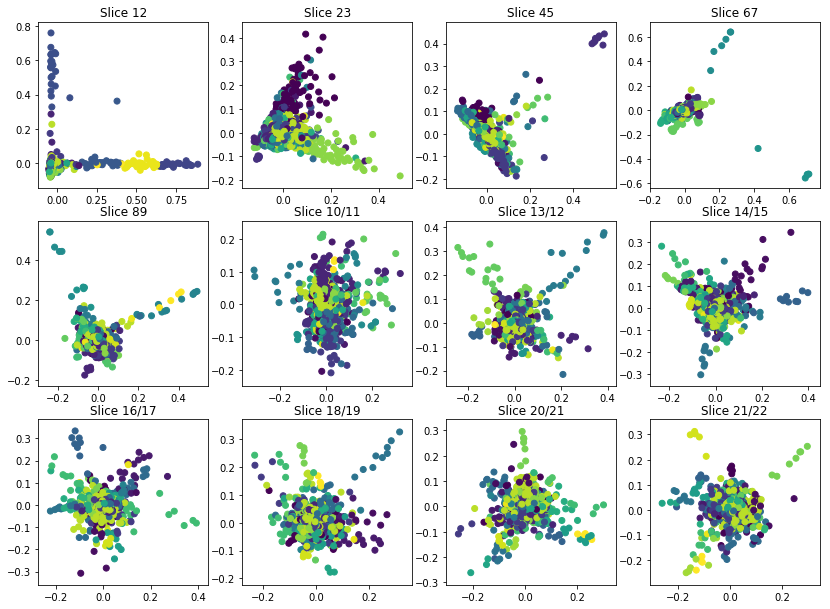

In [49]:

plt.figure(figsize=(14, 14))

plt.subplot(441)
plt.scatter(corpus_lsi_dense[:, 0], corpus_lsi_dense[:, 1], c=pred)
plt.title("Slice 12")


plt.subplot(442)
plt.scatter(corpus_lsi_dense[:, 2], corpus_lsi_dense[:, 3], c=pred)
plt.title("Slice 23")

plt.subplot(443)
plt.scatter(corpus_lsi_dense[:, 4], corpus_lsi_dense[:, 5], c=pred)
plt.title("Slice 45")

plt.subplot(444)
plt.scatter(corpus_lsi_dense[:, 6], corpus_lsi_dense[:, 7], c=pred)
plt.title("Slice 67")

plt.subplot(445)
plt.scatter(corpus_lsi_dense[:, 8], corpus_lsi_dense[:, 9], c=pred)
plt.title("Slice 89")

plt.subplot(446)
plt.scatter(corpus_lsi_dense[:, 10], corpus_lsi_dense[:, 11], c=pred)
plt.title("Slice 10/11")

plt.subplot(447)
plt.scatter(corpus_lsi_dense[:, 13], corpus_lsi_dense[:, 12], c=pred)
plt.title("Slice 13/12")

plt.subplot(448)
plt.scatter(corpus_lsi_dense[:, 14], corpus_lsi_dense[:, 15], c=pred)
plt.title("Slice 14/15")

plt.subplot(4,4,9)
plt.scatter(corpus_lsi_dense[:, 16], corpus_lsi_dense[:, 17], c=pred)
plt.title("Slice 16/17")

plt.subplot(4,4,10)
plt.scatter(corpus_lsi_dense[:, 18], corpus_lsi_dense[:, 19], c=pred)
plt.title("Slice 18/19")


plt.subplot(4,4,11)
plt.scatter(corpus_lsi_dense[:, 20], corpus_lsi_dense[:, 21], c=pred)
plt.title("Slice 20/21")

plt.subplot(4,4,12)
plt.scatter(corpus_lsi_dense[:, 21], corpus_lsi_dense[:, 22], c=pred)
plt.title("Slice 21/22")

plt.show()

In [45]:
from collections import defaultdict

g1=[]
groups=defaultdict.fromkeys(np.unique(pred),[])
for i in range(0,pred.size):
    tid=subd.columns.levels[0][i]
    title=movd[movd.imdb_id == tid]['Title'].values[0]
    if pred[i] == 1:
        g1.append(title)
g1

['The Money Pit',
 'The Bodyguard',
 'Sliding Doors',
 'The Ring',
 'Van Helsing',
 'White Noise',
 'Closer',
 'The Ring Two',
 'The Eye',
 'Vantage Point',
 'I Am Legend',
 'Something Borrowed',
 'The Uninvited',
 'When the Bough Breaks',
 'Anna Karenina',
 'Frozen',
 'The Girl on the Train',
 'Allied',
 'Fifty Shades Darker']

# Search for similar ones

In [50]:
def search_movie(search_name):
    id=False
    for item in movd['Title']:
        if search_name in item.lower():
            #print(item,movd[movd['Title']==item]['imdb_id'].values[0] )
            id=movd[movd['Title']==item]['imdb_id'].values[0]
    return id  

def find_closest(num):
    imdb_id_random=subd.columns.levels[0][np.random.randint(0,len(subd.columns.levels[0])-1)]
    #query=mtok[imdb_id_random]
    #query=search_movie(input('Name a movie:'))
    #print(query)
    if imdb_id_random:
        movie=mtok[imdb_id_random]
        vec_movie=lsi_mod[tfidf_mod[dictionary.doc2bow(movie)]]
        index.num_best = num
        sims=index[vec_movie]
        print('------Similar titles to: {}------'.format(movd[movd.imdb_id == imdb_id_random]['Title'].values[0]))
        i=1
        for item in sims:
            tid=subd.columns.levels[0][item[0]]
            title=movd[movd.imdb_id == tid]['Title'].values[0]
            print('                       {}.{}'.format(i, title))
            i = i+1
    else:
        print('Movie not found.')
       



In [57]:
find_closest(10)

------Similar titles to: The Kid------
                       1.The Kid
                       2.Bad Moms
                       3.Amy
                       4.Bad Teacher
                       5.Paul Blart: Mall Cop
                       6.Raising Cain
                       7.Congo
                       8.Gone Girl
                       9.Honey, I Shrunk the Kids
                       10.The Amityville Horror
